# Imports

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# Transformations

In [26]:
data_dir = "data"

# Transformacje: resize, konwersja na tensor i normalizacja (ImageNet standard)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # all img to 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# DataLoader

In [27]:
# Załaduj dane
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Klasy:", train_dataset.classes)
print("Klasy:", test_dataset.classes)

Klasy: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Klasy: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Model (CNN)

In [28]:
class FlowerCNN(nn.Module):
    def __init__(self, num_classes):
        super(FlowerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # [16, 64, 64]
        x = self.pool(self.relu(self.conv2(x)))   # [32, 32, 32]
        x = x.view(-1, 32 * 32 * 32)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# Trening

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FlowerCNN(num_classes=len(train_dataset.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {acc:.2f}%")


Epoch [1/10], Loss: 1.3426, Accuracy: 46.40%
Epoch [2/10], Loss: 1.0226, Accuracy: 60.10%
Epoch [3/10], Loss: 0.8372, Accuracy: 68.57%
Epoch [4/10], Loss: 0.6712, Accuracy: 74.98%
Epoch [5/10], Loss: 0.4792, Accuracy: 83.00%
Epoch [6/10], Loss: 0.3066, Accuracy: 90.05%
Epoch [7/10], Loss: 0.1992, Accuracy: 93.80%
Epoch [8/10], Loss: 0.1156, Accuracy: 96.55%
Epoch [9/10], Loss: 0.1298, Accuracy: 96.07%
Epoch [10/10], Loss: 0.0664, Accuracy: 98.06%


# Test uknown images

In [30]:
model.eval()
correct = 0
total = 0

# Statystyki per klasa
num_classes = len(test_dataset.classes)
correct_per_class = [0] * num_classes
total_per_class = [0] * num_classes

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        for i in range(labels.size(0)):
            label = labels[i].item()
            pred = predicted[i].item()
            total_per_class[label] += 1
            if pred == label:
                correct_per_class[label] += 1

# Ogólna dokładność
print(f"Ogólna dokładność: {100 * correct / total:.2f}%")

# Dokładność per klasa
for i, class_name in enumerate(test_dataset.classes):
    acc = 100 * correct_per_class[i] / total_per_class[i]
    print(f"{class_name}: {acc:.2f}%")


Ogólna dokładność: 96.13%
daisy: 96.68%
dandelion: 97.33%
roses: 92.98%
sunflowers: 98.14%
tulips: 95.12%


# Confusion Matrix

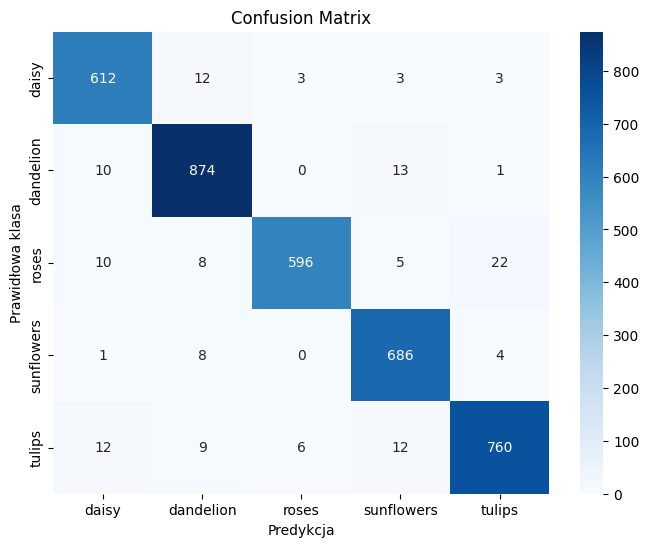

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Zbieramy wszystkie predykcje i etykiety
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Macierz pomyłek
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predykcja')
plt.ylabel('Prawidłowa klasa')
plt.title('Confusion Matrix')
plt.show()


# Show bad classifications

Liczba błędnych klasyfikacji: 142


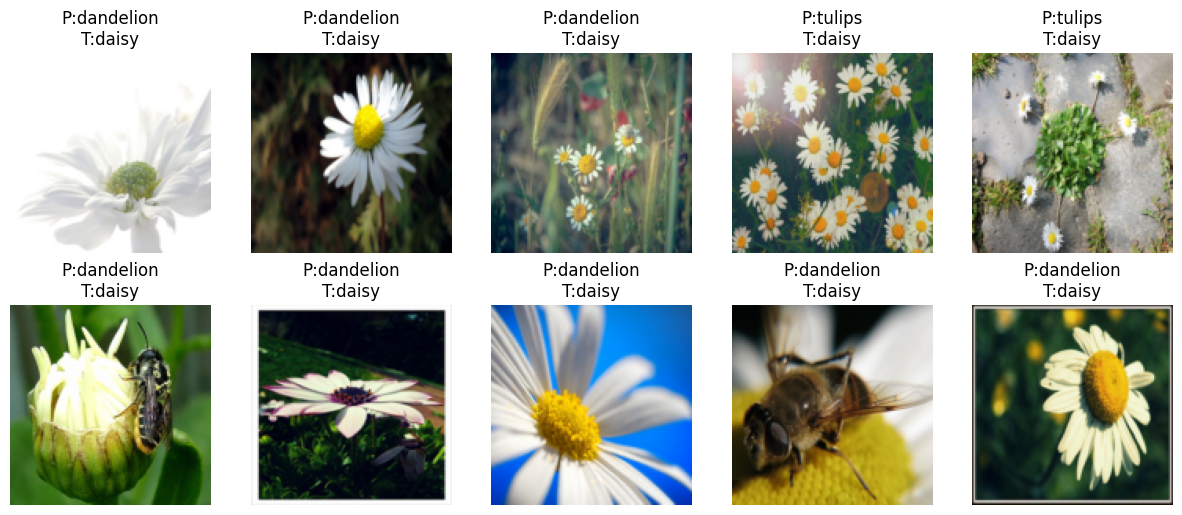

In [32]:
from PIL import Image
import os

wrong_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                wrong_predictions.append((images[i].cpu(), predicted[i].item(), labels[i].item()))

print(f"Liczba błędnych klasyfikacji: {len(wrong_predictions)}")

# Wyświetlamy pierwsze 10 błędów
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, (img, pred, true) in enumerate(wrong_predictions[:10]):
    img = img.permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # odwrócenie normalizacji
    img = np.clip(img.numpy(), 0, 1)
    axes[idx // 5, idx % 5].imshow(img)
    axes[idx // 5, idx % 5].set_title(f"P:{class_names[pred]}\nT:{class_names[true]}")
    axes[idx // 5, idx % 5].axis('off')
plt.show()
